In [24]:
import pandas as pd
import numpy as np
import nibabel as nib
import joblib

DATA_DIR = ''
#---------------------------------------#
#--------------load sMRI----------------#
#---------------------------------------#
ukbb_sMRI = pd.read_csv(DATA_DIR)
ukbb_sMRI = ukbb_sMRI.iloc[:, ~ukbb_sMRI.columns.str.contains('-3.0')]
ukbb_sMRI.index = pd.Index(ukbb_sMRI['eid'])
ukbb_sMRI = ukbb_sMRI.drop(columns='eid')
ukbb_sMRI = ukbb_sMRI.dropna()

#brain region label
descr_dict = pd.read_csv(DATA_DIR,index_col=False,names=['id','name'])
descr_dict.sort_values('id',inplace=True)
sMRI_name_list = descr_dict['name'].to_list()
sMRI_name = [i.split('\tVolume of grey matter in ')[1] for i in sMRI_name_list]

#---------------------------------------#
#--------------load dMRI----------------#
#---------------------------------------#
ukbb_dMRI = pd.read_csv(DATA_DIR)
ukbb_dMRI = ukbb_dMRI.iloc[:,~ukbb_dMRI.columns.str.contains('-3.0')]
ukbb_dMRI = ukbb_dMRI.iloc[:,0:49]

ukbb_dMRI.index = ukbb_dMRI['eid']
ukbb_dMRI = ukbb_dMRI.drop(columns='eid')
ukbb_dMRI = ukbb_dMRI.dropna()

dMRI_name_all = pd.read_csv(DATA_DIR, names=['eid','name'])
dMRI_name_all = dMRI_name_all.iloc[0:48,:]
dMRI_name = []
for i in range(dMRI_name_all.shape[0]):
    new_name = dMRI_name_all.iloc[i,1].split('FA in ')[1]
    dMRI_name.append(new_name)

#---------------------------------------#
#--------------load rfMRI----------------#
#---------------------------------------#
# load rfmri_network
TAR_ANA = 'rfMRI_partialcorr_matrix_dim25'
TAR_ITEMS_PER_SUB = 210
n_networks = 21  # n * (n - 1) / 2

f = open(DATA_DIR, 'r')
good_comps = np.array([line.strip('\n') for line in f.readlines()])
f.close()

subids, sub_corrs = joblib.load(DATA_DIR+'dump_%s' % TAR_ANA)
ukbb_rfMRI = pd.DataFrame(sub_corrs, index=subids)

#---------------------------------------#
#------------load demography------------#
#---------------------------------------#
data_social = pd.read_csv(DATA_DIR+'')
data_sex = data_social[['eid','31-0.0']]
data_sex.index= data_sex['eid']
data_sex = data_sex.drop(columns='eid')
data_age = pd.read_csv(DATA_DIR+'')
data_age.index = data_age['eid']
data_age = data_age.drop(columns='eid')

data_shif = pd.read_csv(DATA_DIR+'')
data_shif.index = data_shif['eid']
data_shif = data_shif[['826-0.0', '3426-0.0',
                       '826-2.0', '3426-2.0']] # shiftwork, night shiftwork#######

data_sleep = pd.read_csv(DATA_DIR+'')
data_sleep.set_index('eid', inplace=True)

#imputation fuction
np.random.seed(0)

def impute_miss(df, df_index):
    new_df = pd.DataFrame(index = df_index)
    for col in df.columns:
        #print(df[col].dtypes)
        arr = pd.to_numeric(df[col])
        #print(arr.value_counts())
        arr = np.array(arr)
        #print(f’Replacing %i NaN values for {col}!' % np.sum(np.isnan(arr)))
        b_nan = np.isnan(arr)
        arr[b_nan] = np.random.choice(arr[~b_nan], np.sum(b_nan))
        new_df[col] = arr 
    return new_df

data_sleep[data_sleep<0] = np.nan
data_sleep_new = impute_miss(data_sleep, data_sleep.index)

## selected consistent subjects & drop shift workers

In [25]:
df_chronotype_0 = data_sleep_new[['1180-0.0']] # 1180-0.0 - Initial visit
df_chronotype_1 = data_sleep_new[['1180-2.0']] # 1180-2.0 - Brain-imaging visit

df_all_chronotype = pd.concat([df_chronotype_0,df_chronotype_1],axis=1)
# binarize chronotype
df_all_chronotype['1180-0.0'][df_all_chronotype['1180-0.0']<3] = 0 # morning
df_all_chronotype['1180-0.0'][df_all_chronotype['1180-0.0']>2] = 1 # evening
df_all_chronotype['1180-2.0'][df_all_chronotype['1180-2.0']<3] = 0 # morning
df_all_chronotype['1180-2.0'][df_all_chronotype['1180-2.0']>2] = 1 # evening

inconsist_sub=[]
for sub in df_all_chronotype.index:
    if df_all_chronotype['1180-0.0'][sub] != df_all_chronotype['1180-2.0'][sub] :
        inconsist_sub.append(sub)

# drop inconsistent people
df_concat = pd.concat([data_shif,data_sleep_new],axis=1)
df_concat = df_concat.drop(index=inconsist_sub)
# drop shiftwork people
df_concat = df_concat[~(df_concat['826-0.0'] >1 )] # drop shiftwork people: 1-never, 2-sometimes, 3-usually, 4-often
df_concat = df_concat[~(df_concat['3426-0.0'] >1 )] # drop night shiftwork people
df_concat = df_concat[~(df_concat['826-2.0'] >1 )] # drop shiftwork people
df_concat = df_concat[~(df_concat['3426-2.0'] >1 )] # drop night shiftwork people

df_chronotype = df_concat['1180-0.0']
con_subj = []
for i in df_chronotype.index :
    if (i in ukbb_sMRI.index) & (i in ukbb_dMRI.index) & (i in ukbb_rfMRI.index) : # have all brainimage modalities
        con_subj.append(i)

df_sMRI = ukbb_sMRI.loc[con_subj]
df_dMRI = ukbb_dMRI.loc[con_subj]
df_rfMRI = ukbb_rfMRI.loc[con_subj]
df_chronotype = df_chronotype.loc[con_subj]
df_chronotype = df_chronotype.to_frame()

## Demographics

In [26]:
df_age = data_age.loc[con_subj]
df_sex = data_sex.loc[con_subj]
df_sleep = data_sleep_new.loc[con_subj]
df_age.describe()

,21022-0.0
count,27030.000000
mean,55.375213
std,7.393519
min,40.000000
25%,50.000000
50%,56.000000
75%,61.000000
max,70.000000


In [27]:
df_sex.value_counts()

31-0.0
0.0       14715
1.0       12315
dtype: int64

In [28]:
df_temp_sleep = df_sleep.copy()
# drop every "-0.0" column
df_temp_sleep = df_temp_sleep.iloc[:,df_temp_sleep.columns.str.contains('-2.0')]
df_temp_sleep = df_temp_sleep.drop(columns='1180-2.0')
df_temp_chronotype = df_chronotype.copy()
df_temp_chronotype['1180-0.0'][df_temp_chronotype['1180-0.0']<3] = 0 # morning
df_temp_chronotype['1180-0.0'][df_temp_chronotype['1180-0.0']>2] = 1 # evening
df_demographic = pd.concat([df_temp_chronotype,df_sex,df_age,df_temp_sleep],axis=1)

#grouped by chronotype
df_dg_morning = df_demographic.loc[df_demographic['1180-0.0']==0]
df_dg_evening = df_demographic.loc[df_demographic['1180-0.0']==1]

In [29]:
df_dg_morning.describe()

,1180-0.0,31-0.0,21022-0.0,1160-2.0,1190-2.0,1200-2.0,1210-2.0,1220-2.0
count,17995.0,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000
mean,0.0,0.451681,55.708363,7.135593,1.492970,2.104029,1.652848,0.258238
std,0.0,0.497674,7.286212,1.013830,0.606908,0.723817,0.476078,0.486506
min,0.0,0.000000,40.000000,2.000000,1.000000,1.000000,1.000000,0.000000
25%,0.0,0.000000,50.000000,7.000000,1.000000,2.000000,1.000000,0.000000
50%,0.0,0.000000,57.000000,7.000000,1.000000,2.000000,2.000000,0.000000
75%,0.0,1.000000,61.000000,8.000000,2.000000,3.000000,2.000000,0.000000
max,0.0,1.000000,70.000000,16.000000,3.000000,3.000000,2.000000,2.000000


In [30]:
df_dg_morning['31-0.0'].value_counts() # sex

0.0    9867
1.0    8128
Name: 31-0.0, dtype: int64

In [31]:
df_dg_evening.describe()

,1180-0.0,31-0.0,21022-0.0,1160-2.0,1190-2.0,1200-2.0,1210-2.0,1220-2.0
count,9035.0,9035.000000,9035.000000,9035.000000,9035.000000,9035.000000,9035.000000,9035.000000
mean,1.0,0.463420,54.711677,7.215274,1.455894,2.084228,1.624239,0.244272
std,0.0,0.498688,7.559519,1.032368,0.592101,0.732020,0.484346,0.483499
min,1.0,0.000000,40.000000,3.000000,1.000000,1.000000,1.000000,0.000000
25%,1.0,0.000000,49.000000,7.000000,1.000000,2.000000,1.000000,0.000000
50%,1.0,0.000000,55.000000,7.000000,1.000000,2.000000,2.000000,0.000000
75%,1.0,1.000000,61.000000,8.000000,2.000000,3.000000,2.000000,0.000000
max,1.0,1.000000,70.000000,15.000000,3.000000,3.000000,2.000000,2.000000


In [32]:
df_dg_evening['31-0.0'].value_counts() # sex

0.0    4848
1.0    4187
Name: 31-0.0, dtype: int64

## functions

In [33]:
#----------------------------------------------------------#
#---------------define bootstrap and LDA-------------------#
#----------------------------------------------------------#
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

sc = StandardScaler()

# bootstrap function
def perform_bootstrap(Y, n_samples):

    df_y_test = Y.sample(frac=.1, random_state=0)
    df_y_train = Y[~Y.index.isin(df_y_test.index)]
    test_samples = df_y_test.index

    count_y_train = df_y_train.value_counts()
    minority_y = count_y_train.min()

    bootstrap_samples = []
    for _ in range(n_samples):
        # each sample have same probablity to be choiced
        np.random.seed(_)
        class0 = resample(df_y_train[df_y_train==0].dropna(), n_samples = minority_y, replace=True)
        class1 = resample(df_y_train[df_y_train==1].dropna(), n_samples = minority_y, replace=True)
        df_resmapled = pd.concat([class0, class1],axis=0) # type: ignore
        bootstrap_samples.append(df_resmapled.index.to_list())
    return bootstrap_samples, test_samples

def calculate_feature_coef(X, Y, n_BS_itr):

    samples, test_sample = perform_bootstrap(Y, n_BS_itr)
    # LDA modelling
    lda = LDA()

    lda_estimator = np.zeros((n_BS_itr,X.shape[1]))
    # feature_weights = []
    for i, sample in enumerate(samples):
        X_train = X.loc[sample].values
        y_train = Y.loc[sample].values
        y_train = np.ravel(y_train)

        # X_test = X.loc[test_sample].values
        # y_test = Y.loc[test_sample].values
        # y_test = np.ravel(y_test)

        model = lda.fit(X_train, y_train)
        lda_estimator[i,:] = model.coef_

    return lda_estimator

def calculate_significant_coef(lda_estimator,feat_names, alpha):
    
    coef_mean = lda_estimator.mean(axis=0)
    df_coef = pd.DataFrame(coef_mean.T,index=feat_names, columns=['coef'])

    lower_bound = np.percentile(lda_estimator, alpha/2, axis=0)
    upper_bound = np.percentile(lda_estimator, 100-alpha/2, axis=0)
    e_low = coef_mean-lower_bound
    e_up = upper_bound-coef_mean

    xerr = [e_low, e_up]
    df_xerr = pd.DataFrame(np.array(xerr).T,columns=['lower','upoper'],index=df_coef.index)

    bool_arry =((lower_bound>0) | (upper_bound<0))
    df_coef_masked = df_coef.copy()
    df_coef_masked = df_coef_masked[bool_arry]
    df_xerr_masked = df_xerr.loc[df_coef_masked.index]

    df_coef_withNan = df_coef.copy()
    df_coef_withNan[~bool_arry] = np.nan

    assym_err = df_xerr_masked.values.T
    fig, ax = plt.subplots()
    ax.barh(df_coef_masked.index,df_coef_masked['coef'],xerr=assym_err)
    title = str(100-alpha/2)+'% CI coef'
    ax.set_title(title)

    # save all mean coef and CI bound
    df_bound = pd.DataFrame(np.array([lower_bound,upper_bound]).T,columns=['lower','upper'],index=df_coef.index)
    df_coef_all = pd.concat([df_coef,df_bound],axis=1)

    return df_coef_masked, df_coef_withNan, df_coef_all

In [34]:
#######################################################
#          DECONFOUNDING THE BRAIN DATA               #
#######################################################
def deconf(X, subj_index):
    # deconfound the brain space once - behavior one-by-one later
    from nilearn.signal import clean
    from sklearn.preprocessing import StandardScaler
    
    sc = StandardScaler()
    X = sc.fit_transform(X)

    con_subj = subj_index.to_list()

    beh = pd.read_csv(DATA_DIR+'ukb_deconfond.csv')
    beh.index = beh['eid']
    beh = beh.drop(columns='eid')
    beh = beh.loc[con_subj]

    # sleep phenotypes
    sleep_pheno = df_sleep.iloc[:,df_sleep.columns.str.contains('2.0')]
    sleep_pheno = sleep_pheno.loc[con_subj]
    sleep_duration = StandardScaler().fit_transform(sleep_pheno['1160-2.0'].values[:, np.newaxis]) # sleep duration
    sleep_insomnia = sleep_pheno['1200-2.0'].values # insomnia / sleeplessness
    sleep_snoring = sleep_pheno['1210-2.0'].values # snoring
    sleep_dozing = sleep_pheno['1220-2.0'].values # dozing
    sleep_nap = sleep_pheno['1190-2.0'].values # nap

    # Mean rfMRI head motion
    head_motion_rest = np.nan_to_num(
        beh['25741-2.0'].values
    )
    # Mean tfMRI head motion
    head_motion_task = np.nan_to_num(
        beh['25742-2.0'].values
    )
    # Volume of grey matter
    head_size = np.nan_to_num(
        beh['25006-2.0'].values
    )
    # BMI
    body_mass = np.nan_to_num(
        beh['21001-0.0'].values
    )

    # motivated by Elliott et al., 2018
    # exact location of the head and the radio-frequency
    # receiver coil in the scanner
    head_pos_x = np.nan_to_num(
        beh['25756-2.0'].values 
    )
    head_pos_y = np.nan_to_num(
        beh['25757-2.0'].values
    )
    head_pos_z = np.nan_to_num(
        beh['25758-2.0'].values
    )
    head_pos_table = np.nan_to_num(
        beh['25759-2.0'].values
    )
    scan_site_dummies = pd.get_dummies(
        beh['54-2.0']
    ).values

    assert not np.any(np.isnan(head_motion_rest))
    assert not np.any(np.isnan(head_motion_task))
    assert not np.any(np.isnan(head_size))
    assert not np.any(np.isnan(body_mass))

    print('Deconfounding brain feature space!')
    conf_mat = np.hstack([
        sleep_duration,
        np.atleast_2d(sleep_insomnia).T,
        np.atleast_2d(sleep_nap).T,
        np.atleast_2d(sleep_snoring).T,
        np.atleast_2d(sleep_dozing).T,
        np.atleast_2d(head_motion_rest).T, np.atleast_2d(head_motion_task).T,
        np.atleast_2d(head_size).T, np.atleast_2d(body_mass).T,
        np.atleast_2d(head_pos_x).T, np.atleast_2d(head_pos_y).T,
        np.atleast_2d(head_pos_z).T, np.atleast_2d(head_pos_table).T,
        np.atleast_2d(scan_site_dummies)
        ])

    print(len(X))
    print(len(conf_mat))
    X = clean(X, confounds=conf_mat, detrend=False, standardize=False)
    return X

## sMRI

Deconfounding brain feature space!
27030
27030


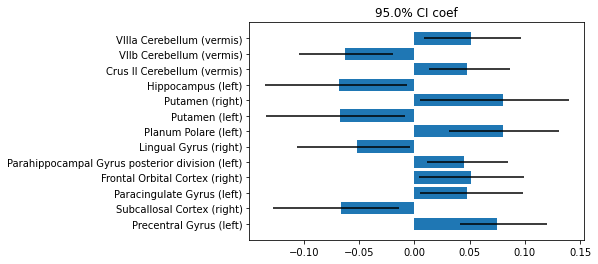

In [35]:
df_target = df_chronotype.copy()
df_target[df_target<3] = 0
df_target[df_target>2] = 1

X = ukbb_sMRI.loc[df_target.index].values
X = deconf(X, df_target.index)
df_input = pd.DataFrame(X, index=df_target.index, columns=sMRI_name)

n_BS_itr = 100
alpha = 10
lda_estimator = calculate_feature_coef(df_input, df_target, n_BS_itr)
significant_coef,df_coef_with_nan,df_coef_all = calculate_significant_coef(lda_estimator, sMRI_name, alpha)
df_coef_all.to_csv('../results/LDA_sMRI_coef_5-95CI_all.csv')

## diffusion MRI

Deconfounding brain feature space!
27030
27030


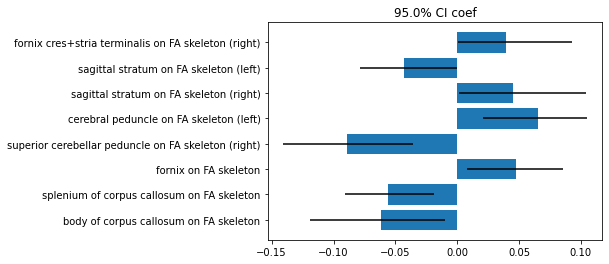

In [36]:
df_target = df_chronotype.copy()
df_target[df_target<3] = 0
df_target[df_target>2] = 1

X = ukbb_dMRI.loc[df_target.index].values
X = deconf(X, df_target.index)
df_input = pd.DataFrame(X, index=df_target.index, columns=dMRI_name)

n_BS_itr = 100
alpha = 10
lda_estimator = calculate_feature_coef(df_input, df_target, n_BS_itr)
significant_coef,df_coef_with_nan,df_coef_all = calculate_significant_coef(lda_estimator, dMRI_name, alpha)
df_coef_all.to_csv('../results/LDA_dMRI_coef_5-95CI_all.csv')

## rest fMRI

In [37]:
df_target = df_chronotype.copy()
df_target[df_target<3] = 0
df_target[df_target>2] = 1

X = ukbb_rfMRI.loc[df_target.index].values
X = deconf(X, df_target.index)
df_input = pd.DataFrame(X, index=df_target.index)

n_BS_itr = 100
lda_estimator = calculate_feature_coef(df_input, df_target, n_BS_itr)

Deconfounding brain feature space!
27030
27030


Text(0.5, 1.0, '5.0-95.0% CI Coef of LDA: morning Vs evening')

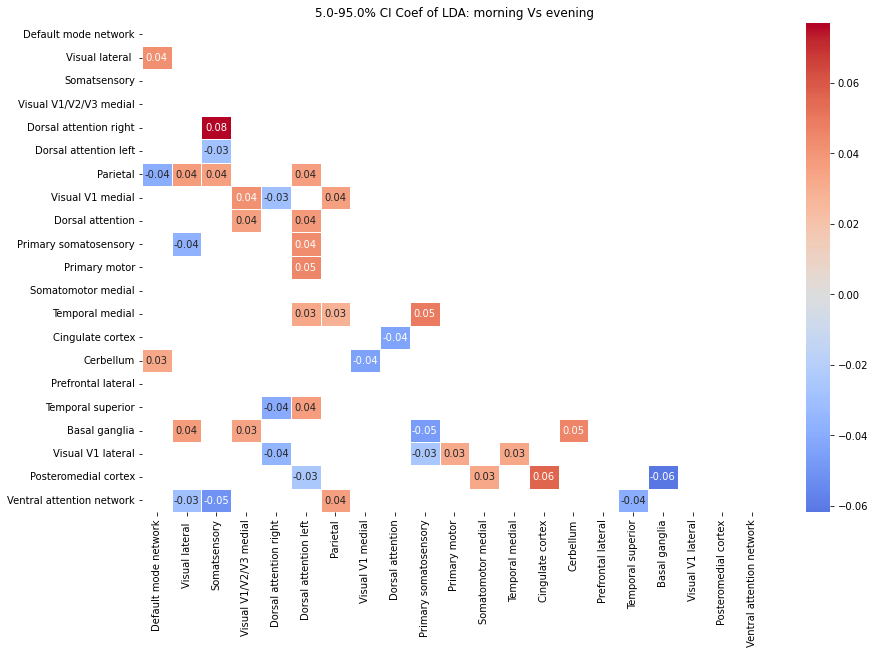

In [38]:
coef_mean = lda_estimator.mean(axis=0)
coef_std  = lda_estimator.std(axis=0)
df_coef = pd.DataFrame(coef_mean.T, columns=['coef'])

alpha = 10
lower_bound = np.percentile(lda_estimator, alpha/2, axis=0)
upper_bound = np.percentile(lda_estimator, 100-alpha/2, axis=0)
e_low = coef_mean-lower_bound
e_up = upper_bound-coef_mean
xerr = [e_low,e_up]

bool_arry =((lower_bound>0) | (upper_bound<0))
coef_masked = coef_mean.copy()
coef_masked[~bool_arry] = np.nan

Matrix_coef = np.zeros((21,21))
Matrix_coef[np.tril_indices(21,k=0)] = 1
Matrix_coef[np.tril_indices(21,k=-1)] = coef_masked
df_matrix = pd.DataFrame(Matrix_coef, columns=good_comps, index=good_comps)

mask = np.triu(np.ones_like(Matrix_coef, dtype=bool))
fig, ax = plt.subplots(figsize=(14, 9))
sns.heatmap(df_matrix, mask=mask, center=0, cmap='coolwarm',annot=True, fmt=".2f", linewidth=0.5)
title = str(alpha/2) + '-' + str(100-alpha/2) + '% CI Coef of LDA: morning Vs evening'
ax.set_title(title)

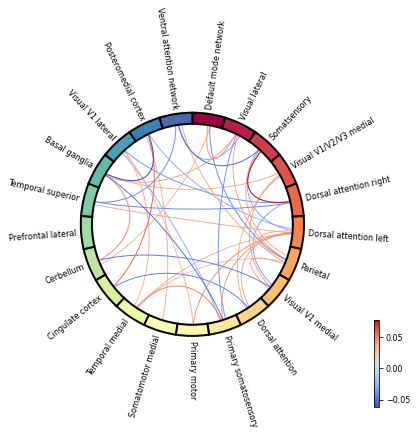

In [39]:
from mne_connectivity.viz import plot_connectivity_circle
from mne.viz import circular_layout

node_order = list()
node_order.extend(good_comps[::-1])
node_angles = circular_layout(good_comps, node_order, start_pos=90)

M_z_ft = Matrix_coef.copy()

crcfig, ax = plot_connectivity_circle(
    con=M_z_ft,
    node_names=good_comps,
    padding=6, linewidth=1,
    facecolor='white',
    fontsize_title=14,
    colormap='coolwarm',
    textcolor='black',
    node_angles = node_angles,
    )

## Sex differences

### sMRI

Deconfounding brain feature space!
27030
27030


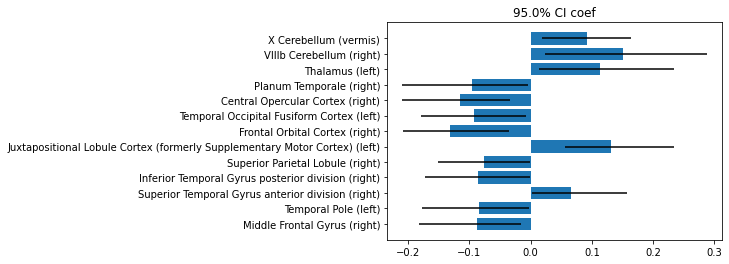

In [19]:
df_target = df_chronotype.copy()
df_target[df_target<3] = 0
df_target[df_target>2] = 1

X = ukbb_sMRI.loc[df_target.index].values
X = deconf(X, df_target.index)
df_input = pd.DataFrame(X, index=df_target.index, columns=sMRI_name)

# Split dataset by sex
male_data = df_input[df_sex['31-0.0'] == 1]
female_data = df_input[df_sex['31-0.0'] == 0]
male_y = df_target.loc[male_data.index]
female_y = df_target.loc[female_data.index]

n_BS_itr = 100
alpha = 10

male_coef = calculate_feature_coef(male_data, male_y, n_BS_itr)
female_coef = calculate_feature_coef(female_data, female_y, n_BS_itr)

# calculating differences
diff = male_coef - female_coef
significant_coef,sexdiff_coef_withNan,sexdiff_coef_all = calculate_significant_coef(diff, sMRI_name, alpha)
sexdiff_coef_all.to_csv('../results/LDA_sexdiff_sMRI_coef_5-95CI_all.csv')

### dMRI

Deconfounding brain feature space!
27030
27030


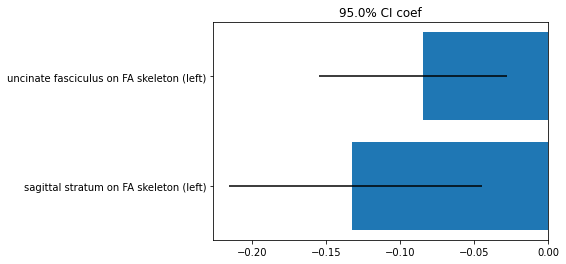

In [20]:
df_target = df_chronotype.copy()
df_target[df_target<3] = 0
df_target[df_target>2] = 1

X = ukbb_dMRI.loc[df_target.index].values
X = deconf(X, df_target.index)
df_input = pd.DataFrame(X, index=df_target.index, columns=dMRI_name)

# Split dataset by sex
male_data = df_input[df_sex['31-0.0'] == 1]
female_data = df_input[df_sex['31-0.0'] == 0]
male_y = df_target.loc[male_data.index]
female_y = df_target.loc[female_data.index]

n_BS_itr = 100
alpha = 10

male_coef = calculate_feature_coef(male_data, male_y, n_BS_itr)
female_coef = calculate_feature_coef(female_data, female_y, n_BS_itr)

# calculating differences
diff = male_coef - female_coef
significant_coef,sexdiff_coef_withNan,sexdiff_coef_all = calculate_significant_coef(diff, dMRI_name, alpha)
sexdiff_coef_all.to_csv('../results/LDA_sexdiff_dMRI_coef_5-95CI_all.csv')

### resting-state fMRI

Deconfounding brain feature space!
27030
27030


Text(0.5, 1.0, '95.0% CI Coef')

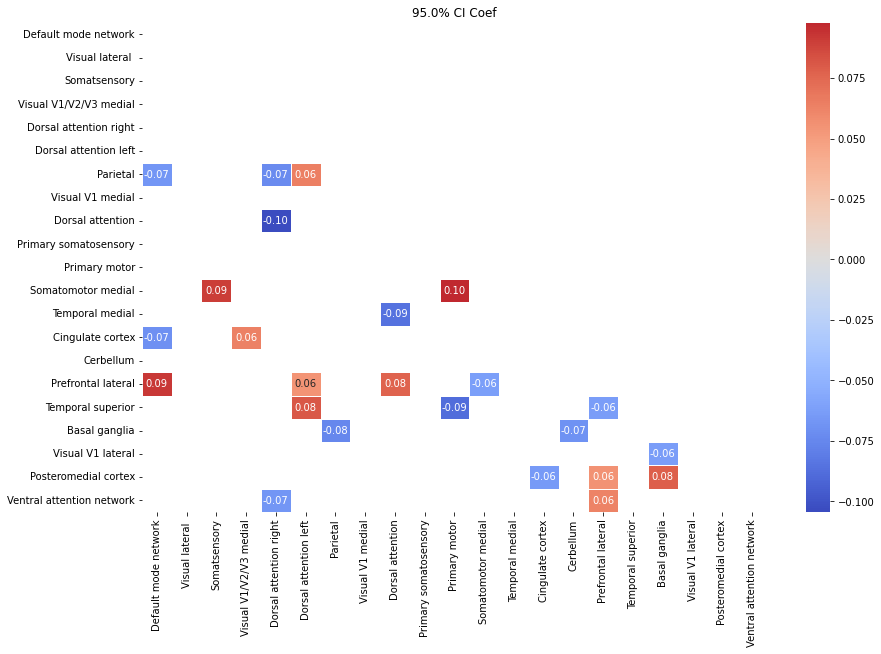

In [22]:
df_target = df_chronotype.copy()
df_target[df_target<3] = 0
df_target[df_target>2] = 1

X = ukbb_rfMRI.loc[df_target.index].values
X = deconf(X, df_target.index)

df_input = pd.DataFrame(X, index=df_target.index)

# Split dataset by sex
male_data = df_input[df_sex['31-0.0'] == 1]
female_data = df_input[df_sex['31-0.0'] == 0]
male_y = df_target.loc[male_data.index]
female_y = df_target.loc[female_data.index]

n_BS_itr = 100
alpha = 10

male_coef = calculate_feature_coef(male_data, male_y, n_BS_itr)
female_coef = calculate_feature_coef(female_data, female_y, n_BS_itr)

# calculating differences
diff = male_coef - female_coef
coef_mean = diff.mean(axis=0)

lower_bound = np.percentile(diff, alpha/2, axis=0)
upper_bound = np.percentile(diff, 100-alpha/2, axis=0)
e_low = coef_mean-lower_bound
e_up = upper_bound-coef_mean
xerr = [e_low,e_up]

bool_arry =((lower_bound>0) | (upper_bound<0))
coef_masked = coef_mean.copy()
coef_masked[~bool_arry] = np.nan

Matrix_coef = np.zeros((21,21))
tril_mask = np.tril(np.ones((21,21),dtype=bool),k=-1)
Matrix_coef[tril_mask] = coef_masked
df_matrix = pd.DataFrame(Matrix_coef, columns=good_comps, index=good_comps)
# df_matrix.to_csv('../results/LDA_rfMRI_sexdiff_coef_5-95CI.csv')

import seaborn as sns
mask = np.triu(np.ones_like(Matrix_coef, dtype=bool))
#np.fill_diagonal(mask, False)
fig, ax = plt.subplots(figsize=(14, 9))
sns.heatmap(df_matrix, mask=mask, center=0, cmap='coolwarm',annot=True, fmt=".2f", linewidth=0.5)
title = str(100-alpha/2) + '% CI Coef'
ax.set_title(title)

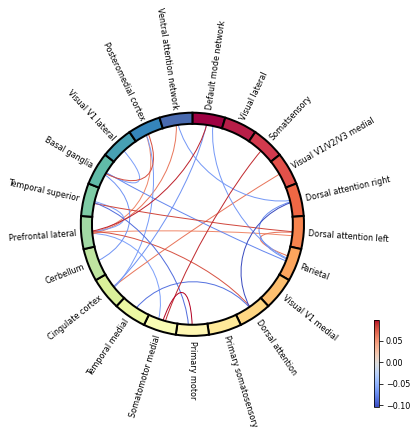

In [23]:
from mne_connectivity.viz import plot_connectivity_circle
from mne.viz import circular_layout

node_order = list()
node_order.extend(good_comps[::-1])
node_angles = circular_layout(good_comps, node_order, start_pos=90)

M_z_ft = Matrix_coef.copy()
Y_comp_weights = M_z_ft

crcfig, ax = plot_connectivity_circle(
    con=M_z_ft,
    node_names=good_comps,
    padding=6, linewidth=1,
    # vmin=0, 
    # vmax=0.16,
    facecolor='white',
    fontsize_title=14,
    colormap='coolwarm',
    textcolor='black',
    node_angles = node_angles,
    )